In [27]:
import numpy as np
import pandas as pd
import matplotlib as plt
import datetime
#turns seconds into a string format ffmpeg uses
def seconds_formatter(sec):
    x = "0" + str(datetime.timedelta(seconds=sec))[:-3]
    return x

In [28]:
df = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\gpDeepCut_resnet50_goprofrontviewJun17shuffle1_30001.h5")
#remove extra level "scorer"
df.columns = df.columns.droplevel()
df.describe()

bodyparts       leftEar                                  rightEar  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         418.129470    104.092916      0.819854    342.438231   
std           59.484658     55.269955      0.345757     61.201473   
min           -0.232820      0.058952      0.000652      1.185614   
25%          410.203378     75.918766      0.963633    317.790530   
50%          431.752412    109.551635      0.999844    332.283849   
75%          443.193016    141.584548      0.999973    346.850670   
max          651.580333    398.199630      0.999999    609.912476   

bodyparts                                      Nose                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         101.684238      0.801598    375.327111    208.523040   
std           58.679316      0.350441     59.976627     70.090319   
min           -2.496538      0.001448      0.344874     18.644475   
25%           64.836136      0.799568    366.916633    149.775522   
50%          103.500209      0.999885    382.856600    222.712812   
75%          142.310630      0.999981    389.395545    261.157506   
max          346.226936      0.999999    623.018394    397.013597   

bodyparts                    leftHand      ...          rightHand  \
coords       likelihood             x      ...         likelihood   
count      24320.000000  24320.000000      ...       24320.000000   
mean           0.789948    401.102718      ...           0.459706   
std            0.335402     42.124632      ...           0.409989   
min            0.002590     64.313986      ...           0.001246   
25%            0.663167    382.997393      ...           0.045521   
50%            0.996328    403.306821      ...           0.325276   
75%            0.999806    426.271711      ...           0.952850   
max            0.999998    652.821492      ...           0.999980   

bodyparts      leftFoot                                 rightFoot  \
coords                x             y    likelihood             x   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         400.000369    211.809658      0.563731    325.880319   
std          106.976893     68.213118      0.431094     36.197824   
min           70.790897      4.613057      0.002174      1.576407   
25%          395.883299    152.843292      0.087321    305.209249   
50%          438.449283    214.538742      0.681825    319.431005   
75%          455.452176    224.842714      0.999839    335.237931   
max          654.890787    395.073073      0.999997    646.668256   

bodyparts                                    pellet                \
coords                y    likelihood             x             y   
count      24320.000000  24320.000000  24320.000000  24320.000000   
mean         193.638297      0.801919    391.551464    295.535599   
std           42.793461      0.327147     38.246815     62.200636   
min            1.647910      0.003355      1.279912      0.627747   
25%          152.980904      0.679855    392.289892    267.040393   
50%          211.355771      0.997711    395.490041    325.472089   
75%          224.876223      0.999907    397.825792    335.043683   
max          396.876828      0.999999    641.452611    395.651502   

bodyparts                
coords       likelihood  
count      24320.000000  
mean           0.634827  
std            0.460287  
min            0.001884  
25%            0.025175  
50%            0.999050  
75%            0.999830  
max            0.999988  

[8 rows x 24 columns]

In [29]:
def frame_to_time(frame):
    total_seconds = (frame/24320)*202
    return round(total_seconds, 3)
def time_to_frame(time):
    return 24320*(time/202)
def dist_from_dispenser(x, y):
    return ((x-396)**2 + (y-325)**2)**0.5
def outside_box(x, y):
    return y > 300

In [30]:
labels = {key: df[df[key, 'likelihood'] > 0.9][key] for key in list(df.columns.levels[0])}
{labels[key].insert(0, "frame", labels[key].index, True) for key in labels.keys()}
{labels[key].insert(0, "time", labels[key]['frame'].map(frame_to_time), True) for key in labels.keys()}
leftEar = labels['leftEar']
rightEar = labels['rightEar']
nose = labels['Nose']
leftHand = labels['leftHand']
rightHand = labels['rightHand']
leftFoot = labels['leftFoot']
rightFoot = labels['rightFoot']
pellet = labels['pellet']
# pellet[(pellet['time'] > 39) & (pellet['time'] < 40)].plot(kind='scatter', x='x', y='y')
# pellet.plot(kind='scatter', x='x', y='y')
# nose.plot(kind='scatter', x='x', y='y')

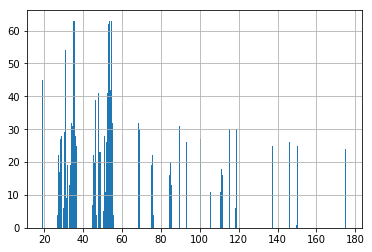

In [31]:
#add distance from dispenser column to the hand dataframe
rightHand['d_from_dispenser'] = rightHand.apply(lambda row: dist_from_dispenser(x = row['x'], y = row['y']), axis=1)
rightHand['outside_of_box'] = rightHand.apply(lambda row: outside_box(x = row['x'], y = row['y']), axis=1)
hand_reach = rightHand[rightHand['d_from_dispenser'] < 40]
# hand_reach = rightHand[rightHand['outside_of_box']]
hand_reach['time'].hist(bins=300)

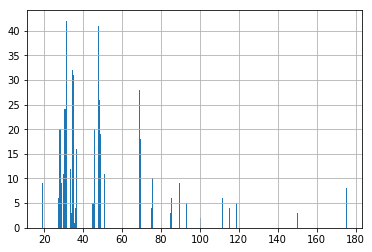

In [32]:
rightHand[rightHand['y'] > 315]['time'].hist(bins=300)

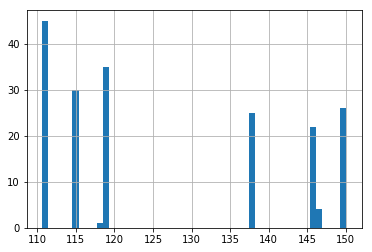

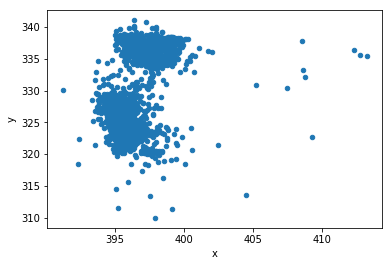

In [33]:
hand_reach = rightHand[(rightHand['d_from_dispenser'] < 40)& (rightHand['time'] < 155) & (rightHand['time'] > 109)]
hand_reach['time'].hist(bins=50)
pellet[(pellet['time'] < 155) & (pellet['time'] > 109)].plot(kind= 'scatter', x='x', y='y')

In [34]:
sum(hand_reach['y'] > 330)

0

## Determining when the mouse is reaching


In [35]:
def get_reaches_frames(hand_df, filter_function):
    """Returns: List of Tuples, where each tuple is a reach, 
    1st element of tuple is start time, 2nd element of tuple is the duration
    
    Given frames where hand is within a set radius, loop through, 
    bunch approximately consecutive frames (within x frames of each other)
    as a single reach. Filter out 'reaches' that are impossibly short.
    """
    hand_reach = hand_df[hand_df.apply(filter_function, axis=1)]
    reaches = []
    last_frame = hand_reach['frame'].values[0]
    consec_frames_ct = 1 #number of consecutive frames
    first_frame_of_reach = last_frame
    for frame in hand_reach['frame'].values:
        if (frame - last_frame < 10):
            consec_frames_ct += 1
        else:
            reaches.append((first_frame_of_reach, consec_frames_ct))
            consec_frames_ct = 1
            first_frame_of_reach = frame
        last_frame = frame
    reaches.append((first_frame_of_reach, consec_frames_ct))
    
    #filter out false positives: reaches that only lasted 2 or less frames
    reaches_filtered = [x for x in reaches if x[1] >= 2]
    return reaches_filtered

### First Method: Basing it off of the distance from dispenser*
*where the pellet is SUPPPOSED to be, currently hard coded pixel coordinates.

In [36]:
def is_near_dispenser(row):
    dist = ((row['x']-396)**2 + (row['y']-325)**2)**0.5
    return dist < 20
get_reaches_frames(rightHand, is_near_dispenser)

[(2276, 18),
 (3303, 14),
 (3390, 29),
 (3458, 34),
 (3652, 35),
 (3730, 48),
 (4024, 30),
 (4104, 29),
 (4193, 114),
 (4352, 21),
 (5410, 29),
 (5497, 16),
 (5743, 41),
 (5834, 43),
 (6143, 29),
 (8247, 32),
 (8324, 18),
 (9046, 9),
 (9101, 13),
 (10179, 19),
 (10248, 17),
 (10789, 30),
 (11213, 13),
 (12098, 9),
 (13326, 20),
 (13397, 16),
 (13843, 7),
 (14268, 11),
 (16557, 12),
 (17577, 5),
 (18048, 14),
 (21101, 19)]

### Second Method: When the hand crosses the line, or outside of the acrylic
Hard coded line

In [37]:
def get_reaches(hand_df, filter_function):
    return [(frame_to_time(x[0]), frame_to_time(x[1])) for x in get_reaches_frames(hand_df, filter_function)]
get_reaches_frames(rightHand, is_near_dispenser)

[(2276, 18),
 (3303, 14),
 (3390, 29),
 (3458, 34),
 (3652, 35),
 (3730, 48),
 (4024, 30),
 (4104, 29),
 (4193, 114),
 (4352, 21),
 (5410, 29),
 (5497, 16),
 (5743, 41),
 (5834, 43),
 (6143, 29),
 (8247, 32),
 (8324, 18),
 (9046, 9),
 (9101, 13),
 (10179, 19),
 (10248, 17),
 (10789, 30),
 (11213, 13),
 (12098, 9),
 (13326, 20),
 (13397, 16),
 (13843, 7),
 (14268, 11),
 (16557, 12),
 (17577, 5),
 (18048, 14),
 (21101, 19)]

In [38]:
def outside_box(row):
    return row['y'] > 300
len(get_reaches(rightHand, outside_box))

37

## Create Compilation of Hand Reaches
Creates a windows batch file

In [39]:
#Open up new batch file
project_name = "goprofrontview"
bat_file= r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}_create_videos.bat".format(project_name)
script_writer= open(bat_file,"w")

#write series of shell commands to create videos for each attempt, connected by '&&' for the batch file
reaches = get_reaches(rightHand, is_near_dispenser)
vids = []
for tpl in reaches:
    start_time = seconds_formatter(max(0, tpl[0] - 2.0))
    cmd = "ffmpeg -i gp.mp4 -ss {0} -t {1} -c copy {2}.mp4".format(start_time, 2.5 + tpl[1], np.round(tpl[0], 3))
    vids.append(str(np.round(tpl[0], 3)) + ".mp4")
    script_writer.write(cmd + " && ")
script_writer.close()

#open and write a list of videos to concatenate (.txt file) for ffmpeg to use
list_file = r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}_video_list.txt".format(project_name)
list_writer = open(list_file, "w+")
for v in vids:
    list_writer.write('file ' + "\'" + r"C:\Users\vjj14\Desktop\DeepLabCut\goprofrontview-vj-2019-06-17\videos\{}".format(v) + "\'\n")
list_writer.close()

#open batch file again and write command to produce a concatenated video, the final product
script_writer = open(bat_file, "a+")
script_writer.write("ffmpeg -f concat -safe 0 -i {0} -c copy output.mp4".format(list_file))
script_writer.close()

## Determining when the pellet is there
### First Method: Based off of distance from dispenser*
*Where the pellet is SUPPOSED to be.

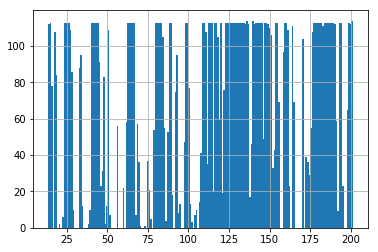

In [40]:
#add distance from dispenser column to the hand dataframe
pellet['d_from_dispenser'] = pellet.apply(lambda row: dist_from_dispenser(x = row['x'], y = row['y']), axis=1)
pellet2 = pellet[pellet['d_from_dispenser'] < 20]
pellet2['time'].hist(bins=200)

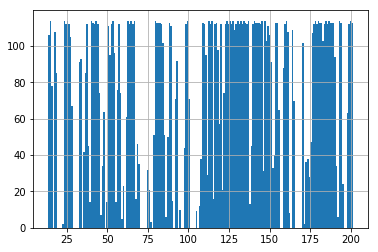

In [41]:
pellet[pellet['likelihood']>0.99]['time'].hist(bins=200)

### Second Method: Using (averaged) likelihood
Based off the observation that pellets in position have much higher likelihoods. I think that this is a bad idea and may not generalize, but the way I did it (averaging frames around it) is an alternate and possibly better way to deal with outliers.

1631


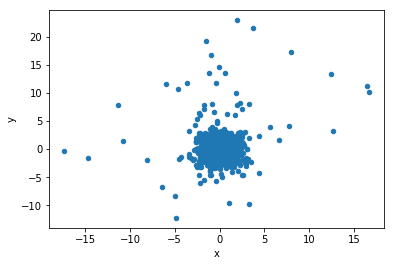

In [42]:
c99 = pellet[pellet['likelihood'] > 0.99]
subset = c99.diff().reset_index()
# subset[(subset['y'] < 1) & (subset['y'] > -1)].plot(kind='scatter', x='index', y='y')
# subset.diff()
# subset['index'].hist(bins=500)
print(min(subset['index']))
max(subset['index'])
subset.plot(kind = 'scatter', x='x', y='y')

In [43]:
array = np.zeros(25000)
for frame in c99['frame']:
    array[frame] = 1.0
temp = array.copy()
for i in range(25, len(array)):
    temp[i] = np.mean(array[i-25:i+25])
#     print(np.mean(array[i-50:i+50]))
array = temp
# np.histogram(array, bins=200, range=(0, 25000))
def experiment():
    results = []
    temp = array > 0.5
    curr_start = 0
    curr_len = 0
    for i in range(len(temp)):
        if temp[i] and curr_len == 0:
            curr_start = i
            curr_len = 1
        elif temp[i]:
            curr_len += 1
        elif not temp[i] and curr_len != 0:
            results.append((curr_start, curr_len))
            curr_len = 0
    
    #filter out false positives: 'reaches' that lasted for less than 0.1 seconds
    results2 = [x for x in results if x[1] > 12] #assuming 120 fps
    results2_time = [(frame_to_time(x[0]), frame_to_time(x[1])) for x in results2]
    return results2_time
print(len(experiment()))
pellet_times = experiment()

33


In [44]:
def get_reaches_frames(hand_df, filter_function):
    """Returns: List of Tuples, where each tuple is a reach, 
    1st element of tuple is start time, 2nd element of tuple is the duration
    
    Given frames where hand is within a set radius, loop through, 
    bunch approximately consecutive frames (within x frames of each other)
    as a single reach. Filter out 'reaches' that are impossibly short.
    """
    hand_reach = hand_df[hand_df.apply(filter_function, axis=1)]
    reaches = []
    last_frame = hand_reach['frame'].values[0]
    consec_frames_ct = 1 #number of consecutive frames
    first_frame_of_reach = last_frame
    for frame in hand_reach['frame'].values:
        if (frame - last_frame < 10):
            consec_frames_ct += 1
        else:
            reaches.append((first_frame_of_reach, consec_frames_ct))
            consec_frames_ct = 1
            first_frame_of_reach = frame
        last_frame = frame
    reaches.append((first_frame_of_reach, consec_frames_ct))
    
    #filter out false positives: reaches that only lasted 2 or less frames
    reaches_filtered = [x for x in reaches if x[1] >= 2]
    return reaches_filtered

In [45]:
np.argwhere(array > 0.5)
pellet2 = pellet[pellet['likelihood'] > 0.99]
def get_pellet_frames(pellet_df, filter_function):
    close_pellets = pellet_df[pellet_df.apply(filter_function, axis=1)]
    pellet_times = []
    last_frame = close_pellets['frame'].values[0]
    consec_frames_ct = 1 #number of consecutive frames
    first_frame_of_pellet = last_frame
    for frame in close_pellets['frame'].values:
        if (frame - last_frame < 18):
            consec_frames_ct += 1
        else:
            pellet_times.append((first_frame_of_pellet, consec_frames_ct))
            consec_frames_ct = 1
            first_frame_of_pellet = frame
        last_frame = frame
    pellet_times.append((first_frame_of_pellet, consec_frames_ct))
    
    #filter out false positives: 'reaches' that lasted for less than 0.1 seconds
    pellet_times_filtered = [x for x in pellet_times if x[1] > 12] #assuming 120 fps
    return pellet_times_filtered
def get_pellet_times(pellet_df, filter_function):
    pellet_times = get_pellet_frames(pellet_df, filter_function)
    return [(frame_to_time(x[0]), frame_to_time(x[1])) for x in pellet_times]
pellet_times = get_pellet_times(pellet, is_near_dispenser)
pellet_times

[(13.58, 2.525),
 (17.376, 1.595),
 (22.916, 5.507),
 (32.559, 1.586),
 (39.777, 5.723),
 (47.111, 0.947),
 (50.085, 1.063),
 (56.048, 0.465),
 (59.686, 0.183),
 (61.904, 5.233),
 (68.474, 0.739),
 (75.144, 0.482),
 (78.823, 6.454),
 (87.279, 2.384),
 (91.789, 1.412),
 (97.653, 2.899),
 (107.138, 0.116),
 (108.027, 3.297),
 (112.014, 3.032),
 (115.818, 2.807),
 (119.132, 1.595),
 (121.815, 15.756),
 (138.95, 7.185),
 (146.691, 5.025),
 (153.053, 2.807),
 (158.211, 3.779),
 (163.751, 1.495),
 (170.379, 0.864),
 (172.788, 0.623),
 (174.757, 0.698),
 (175.978, 15.441),
 (192.756, 2.143),
 (197.922, 3.356)]

In [46]:
def binary_search(p_times, r_time):
    if len(p_times) == 1:
        if (r_time[0] < p_times[0][0]) or (r_time[0] > p_times[0][0] + p_times[0][1]):
            print("No Pellet There " + str(p_times[0]))
            return
        return p_times[0]
    elif r_time[0] > p_times[len(p_times)//2][0]:
        return binary_search(p_times[len(p_times)//2:], r_time)
    else:
        return binary_search(p_times[:len(p_times)//2], r_time)

In [47]:
def find_attempts(reaches, pellet_times):
    attempts = []
    for r in reaches:
        print(r)
        closest_pellet_time_before_reach = binary_search(pellet_times, r)
        print(closest_pellet_time_before_reach)
        if closest_pellet_time_before_reach is not None:
            attempts.append(r)
    return attempts
find_attempts(reaches, pellet_times)

(18.904, 0.15)
(17.376, 1.595)
(27.434, 0.116)
(22.916, 5.507)
(28.157, 0.241)
(22.916, 5.507)
(28.722, 0.282)
No Pellet There (22.916, 5.507)
None
(30.333, 0.291)
No Pellet There (22.916, 5.507)
None
(30.981, 0.399)
No Pellet There (22.916, 5.507)
None
(33.423, 0.249)
(32.559, 1.586)
(34.088, 0.241)
(32.559, 1.586)
(34.827, 0.947)
No Pellet There (32.559, 1.586)
None
(36.147, 0.174)
No Pellet There (32.559, 1.586)
None
(44.935, 0.241)
(39.777, 5.723)
(45.658, 0.133)
No Pellet There (39.777, 5.723)
None
(47.701, 0.341)
(47.111, 0.947)
(48.457, 0.357)
No Pellet There (47.111, 0.947)
None
(51.023, 0.241)
(50.085, 1.063)
(68.499, 0.266)
(68.474, 0.739)
(69.138, 0.15)
(68.474, 0.739)
(75.135, 0.075)
No Pellet There (68.474, 0.739)
None
(75.592, 0.108)
(75.144, 0.482)
(84.546, 0.158)
(78.823, 6.454)
(85.119, 0.141)
(78.823, 6.454)
(89.613, 0.249)
(87.279, 2.384)
(93.134, 0.108)
(91.789, 1.412)
(100.485, 0.075)
(97.653, 2.899)
(110.685, 0.166)
(108.027, 3.297)
(111.274, 0.133)
(108.027, 3.29

[(18.904, 0.15),
 (27.434, 0.116),
 (28.157, 0.241),
 (33.423, 0.249),
 (34.088, 0.241),
 (44.935, 0.241),
 (47.701, 0.341),
 (51.023, 0.241),
 (68.499, 0.266),
 (69.138, 0.15),
 (75.592, 0.108),
 (84.546, 0.158),
 (85.119, 0.141),
 (89.613, 0.249),
 (93.134, 0.108),
 (100.485, 0.075),
 (110.685, 0.166),
 (111.274, 0.133),
 (114.979, 0.058),
 (118.509, 0.091),
 (137.521, 0.1),
 (145.993, 0.042),
 (149.905, 0.116),
 (175.263, 0.158)]

## Trying to identify pellet position automatically

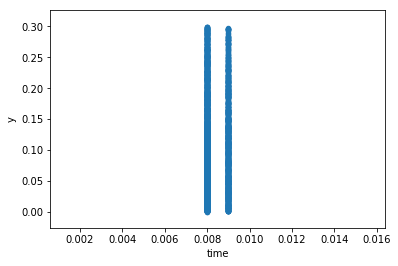

In [48]:
x = pellet.diff()
x = x[(x['x'] < 0.16) & (x['x'] > -0.16)]
x = x[(x['y'] > 0) & (x['y'] < 0.3)]
x.plot(kind='scatter', x = 'time', y='y')

## Random Forest Generator

In [54]:
import random
reaches = get_reaches_frames(rightHand, is_near_dispenser)
standardized_reaches = []
df2 = df.reset_index()
for x, y in reaches:
    if abs(frame_to_time(x) - 105.593) < 0.2:
        print('hi')
        continue
    rh = df2[(df2['index'] > x-3) & (df2['index'] < x + 10)]['rightHand'].values.flatten()
    plt = df2[(df2['index'] > x-3) & (df2['index'] < x + 10)]['pellet'].values.flatten()
    standardized_reaches.append(np.append(rh, plt))
print(len(standardized_reaches))
non_reaches = []
random.seed(46)
while len(non_reaches) < 33:
    #hard code 3 non-reaches
    frame = random.randint(10, 24000)
    if len(non_reaches) == 0:
        frame = 6224
    elif len(non_reaches) == 1:
        frame = 5578
    elif len(non_reaches) == 2:
        frame = 6501
    too_close = False
    for x, y in reaches:
        if abs(frame - x) < 50:
            print('no')
            too_close = True
            break
    if not too_close:
        rh = df2[(df2['index'] > frame-3) & (df2['index'] < frame + 10)]['rightHand'].values.flatten()
        plt = df2[(df2['index'] > frame-3) & (df2['index'] < frame + 10)]['pellet'].values.flatten()
        non_reaches.append(np.append(rh, plt))
print(len(non_reaches))
features = np.append(standardized_reaches, np.asarray(non_reaches), axis=0)
print(len(features))
labels = np.asarray([1 for x in range(33)] + [0 for y in range(33)])
print(len(labels))

32
no
no
33
65
66


In [55]:
def get_dataset(df, cols, start_frames, frames_before, frames_after):
    dataframe = df[cols]
    dataset = []
    for start_f in start_frames:
        temp_df = dataframe.iloc[start_f - frames_before: start_f + frames_after]
        dataset.append(temp_df.values.flatten())
    return np.asarray(dataset)

In [68]:
non_reaches = []
random.seed(46)
while len(non_reaches) < 32:
    #hard code 3 non-reaches
    frame = random.randint(10, 24000)
    if len(non_reaches) == 0:
        frame = 6224
    elif len(non_reaches) == 1:
        frame = 5578
    elif len(non_reaches) == 2:
        frame = 6501
    too_close = False
    for start_time, length in reaches:
        if abs(frame - start_time) < 50:
            print('no')
            too_close = True
            break
    if not too_close:
        non_reaches.append(frame)
        
reach_data = get_dataset(df2, ['rightHand', 'pellet', 'Nose'], [x for x, y in get_reaches_frames(rightHand, is_near_dispenser)], 3, 120)
non_reach_data = get_dataset(df2, ['rightHand', 'pellet', 'Nose'], non_reaches, 3, 120)
features = np.append(reach_data, non_reach_data, axis = 0)
labels = np.asarray([1 for i in range(len(reach_data))] + [0 for i in range(len(non_reach_data))])
reach_data

no
no


array([[3.89914990e+02, 3.17166653e+02, 1.70877203e-01, ...,
        3.80157985e+02, 2.27462409e+02, 9.99956369e-01],
       [3.77553262e+02, 3.13437498e+02, 9.96952891e-01, ...,
        3.80471783e+02, 3.04966409e+02, 9.99715388e-01],
       [3.85287134e+02, 3.22473068e+02, 5.98986596e-02, ...,
        3.83998644e+02, 3.10842820e+02, 9.99773443e-01],
       ...,
       [3.88400088e+02, 2.95530093e+02, 9.91227567e-01, ...,
        3.85495440e+02, 2.80104854e+02, 9.99926448e-01],
       [3.88623170e+02, 2.95277969e+02, 9.99619126e-01, ...,
        3.94124940e+02, 2.68065102e+02, 9.99262154e-01],
       [3.86887105e+02, 3.05060321e+02, 9.42608774e-01, ...,
        4.12836964e+02, 2.05441885e+02, 9.96645510e-01]])

In [66]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
# Split the data into training and testing sets
total_accuracy = 0
def create_classifier(features, labels, test_proportion, random_seed, n_trees):
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = test_proportion, random_state = random_seed)
    print('Training Features Shape:', train_features.shape)
    print('Training Labels Shape:', train_labels.shape)
    print('Testing Features Shape:', test_features.shape)
    print('Testing Labels Shape:', test_labels.shape)
    rf = RandomForestClassifier(n_estimators = n_trees, random_state = random_seed)
    # Train the model on training data
    rf.fit(train_features, train_labels)
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    print(predictions)
    print(test_labels)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    # Print out the mean absolute error (mae)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (sum(errors) / len(test_labels))
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    return rf, total_accuracy
reach_classifier = create_classifier(features, labels, 0.25, 76462, 1000)[0]
for i in range(100):
    total_accuracy += create_classifier(features, labels, 0.25, i, 1000)[1]
print(total_accuracy/100)

Training Features Shape: (48, 1107)
Training Labels Shape: (48,)
Testing Features Shape: (16, 1107)
Testing Labels Shape: (16,)
[1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0]
[1 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0]
Mean Absolute Error: 0.0 degrees.
Accuracy: 100.0 %.
Training Features Shape: (48, 1107)
Training Labels Shape: (48,)
Testing Features Shape: (16, 1107)
Testing Labels Shape: (16,)
[0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1]
[0 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1]
Mean Absolute Error: 0.0 degrees.
Accuracy: 100.0 %.
Training Features Shape: (48, 1107)
Training Labels Shape: (48,)
Testing Features Shape: (16, 1107)
Testing Labels Shape: (16,)
[1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0]
[1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0]
Mean Absolute Error: 0.06 degrees.
Accuracy: 93.75 %.
Training Features Shape: (48, 1107)
Training Labels Shape: (48,)
Testing Features Shape: (16, 1107)
Testing Labels Shape: (16,)
[0 1 1 0 1 0 0 1 0 1 1 1 0 1 1 1]
[0 1 0 0 1 0 0 1 0 0 1 1 0 1 1 1]
Mean Absolute Error: 0.12 degrees.
Accuracy: 87.5 %.
Tra

KeyboardInterrupt: 

In [69]:
def get_predicted_times(classifier, dataframe, columns, frames_before, frames_after, step_size):
    dataframe = dataframe[columns]
    inputs = []
    num_frames = frames_before + frames_after
    for index in range(num_frames, dataframe.shape[0] - num_frames, step_size):
        temp_df = dataframe.iloc[index - frames_before: index + frames_after]
        inputs.append(temp_df.values.flatten())
    inputs = np.asarray(inputs)
    predictions = classifier.predict(inputs)
    return predictions
start_frames = range(15, df2.shape[0] - 15, 6)
predictions = get_predicted_times(reach_classifier, df2, ['rightHand', 'pellet', 'Nose'], 3, 120, 6)


In [70]:
pointfive = []
pointsevenfive = []
pointnine = []
pointninenine = []
for start, prediction in zip(start_frames, predictions):
    if prediction > 0.5:
        pointfive.append(frame_to_time(start))
    if prediction > 0.75:
        pointsevenfive.append(frame_to_time(start))
    if prediction > 0.9:
        pointnine.append(frame_to_time(start))
    if prediction > 0.99:
        pointninenine.append(frame_to_time(start))
print(len(predictions))
print(len(pointfive))
print(len(pointsevenfive))
print(len(pointnine))
print(len(pointninenine))

4013
697
697
697
697


In [72]:
from scipy import stats
def get_starts(lst):
    starts = [lst[0]]
    for i in range(1, len(lst)):
        if lst[i] - lst[i-1] > 0.2:
            starts.append(lst[i])
    return starts
print(len(get_starts(pointfive)))
print(len(get_starts(pointsevenfive)))
print(len(get_starts(pointnine)))
print(len(get_starts(pointninenine)))
str(stats.describe(predictions))
ft_reaches = np.asarray(get_starts(pointnine))
my_reaches = np.asarray([frame_to_time(x) for x, y in get_reaches_frames(rightHand, is_near_dispenser)])
print((ft_reaches))
print((my_reaches))


31
31
31
31
[ 17.368  25.69   31.969  36.505  43.531  46.073  49.512  50.01   51.854
  54.047  66.655  73.482  82.503  87.835  92.071  98.699 103.932 109.563
 113.152 116.939 118.285 135.976 144.448 145.894 146.84  148.286 150.179
 152.372 172.855 173.154 174.1  ]
[ 18.904  27.434  28.157  28.722  30.333  30.981  33.423  34.088  34.827
  36.147  44.935  45.658  47.701  48.457  51.023  68.499  69.138  75.135
  75.592  84.546  85.119  89.613  93.134 100.485 110.685 111.274 114.979
 118.509 137.521 145.993 149.905 175.263]


In [73]:
time_to_frame(54)

6501.3861386138615

In [ ]:
reach_labels = [2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1]

In [ ]:
yeet = pd.read_hdf(r"C:\Users\vjj14\Desktop\DeepLabCut\goprolensfront-vj-2019-06-25\evaluation-results\iteration-0\goprolensfrontJun25-trainset90shuffle1\DeepCut_resnet50_goprolensfrontJun25shuffle1_60002-snapshot-60002.h5")

In [ ]:
yeet